<a href="https://colab.research.google.com/github/Yaswanthyarra/MicroexpressionClassificationUsingCNNandGeneticAlgorithm/blob/main/GUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/CASMEII'

/content/drive/My Drive/CASMEII


In [3]:
dataset_dir = '/content/drive/My Drive/CASMEII/Cropped-updated/Cropped'

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# define constants
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
NUM_EPOCHS = 60

# load the onset and apex frame indices from the Excel sheet
coding_file = pd.read_excel('/content/drive/My Drive/CASMEII/CASME2-coding-20140508.xlsx', sheet_name='Sheet1')

class_labels = coding_file['Estimated Emotion'].values

# define a function to extract the onset and apex frames for each expression
def extract_frames(sequence_path,sequence, subject_num):
    expression_images = []

    #To obtain the onset and apex frame numbers for the given subject and the corresponding sequence from the xlsheet
    subject_data = coding_file.loc[coding_file['Subject'] == subject_num]
    sequence_data = subject_data.loc[subject_data['Filename'] == sequence]
    onset_frame = sequence_data['OnsetFrame'].iloc[0]
    apex_frame = sequence_data['ApexFrame'].iloc[0]
                                                                                                                                                                 
    #To obtain the path to frames corresponding to the apex and onset frame numbers from the sequence of frames for the subject
    onset_frame_path = os.path.join(sequence_path,'reg_img' + str(onset_frame) + '.jpg')
    apex_frame_path = os.path.join(sequence_path, 'reg_img' + str(apex_frame) + '.jpg')
    print(subject_num,apex_frame_path)
    print(subject_num,onset_frame_path)
   
    #To obtain the apex and apex frames from path
    onset_frame = cv2.imread(onset_frame_path)
    apex_frame = cv2.imread(apex_frame_path)
    onset_frame = cv2.cvtColor(onset_frame, cv2.COLOR_BGR2GRAY)
    apex_frame = cv2.cvtColor(apex_frame, cv2.COLOR_BGR2GRAY)
    
    #To apply histogram equalisation to the frames to to enhance the contrast of an image by redistributing the pixel intensities. 
    onset_frame = cv2.equalizeHist(onset_frame)
    apex_frame = cv2.equalizeHist(apex_frame)

    #Resizing extracted frames
    onset_frame = cv2.resize(onset_frame, IMAGE_SIZE)
    apex_frame = cv2.resize(apex_frame, IMAGE_SIZE)

    #Stacking the apex and onset frames together and and appending to the expressin images list
    expression_images.append(np.stack([onset_frame, apex_frame], axis=-1))
    
    return np.array(expression_images)

# create a data generator for the image data
data_generator = ImageDataGenerator(rescale=1./255)

#Setting up several image augmentation parameters that can be used to generate augmented images 
exp_frame_augmentation = {
    'rotation_range': 10,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'brightness_range': [0.5, 1.5],
}


# load the expression folders and extract the onset and apex frames for each subject

#converting the categorical class labels of a classification problem into numerical form
label_dict = {'happiness': 0, 'disgust': 1, 'repression': 2, 'surprise': 3, 'fear': 4, 'others': 6,'sadness':5}

expression_images = []
expression_labels = []

#Looping through all the subjects in the dataset
for subject in os.listdir(dataset_dir):

    subject_num = int(subject[3:])
    subject_dir = os.path.join(dataset_dir, subject)

    #Looping through each sequence for the subject
    for sequence in os.listdir(subject_dir):
        
        sequence_path = os.path.join(subject_dir, sequence)

        #Extracting the onset and apex frames by invoking the extract_frames method
        expression_frames = extract_frames(sequence_path, sequence, subject_num)

        #Obtaining the expression label for the sequence from the xlsheet and appending it to expression_label 
        subject_data = coding_file.loc[coding_file['Subject'] == subject_num]
        sequence_data = subject_data.loc[subject_data['Filename'] == sequence]
        exp_label_category = sequence_data['Estimated Emotion']
        expression_label = label_dict[exp_label_category.values[0]]

        #Adding the extracted frames and the correspoing class label to expression_images and expression_labels
        expression_images.append(expression_frames)
        expression_labels.append(expression_label)

        # Generating augmented images for the fear class
        if expression_label == 4:  # if fear class
            
            for i in range(30):
              print(i,subject_num)

              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)
              
              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)
        
        # Generating augmented images for the sadness class
        if expression_label == 5:  # if sadness class
           
            for i in range(9):
              print(i,subject_num)
              
              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)
              

              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  

        # generate augmented images for the happiness class
        if expression_label == 0:  # if happiness class
        
            for i in range(1):
              print(i,subject_num)

              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)
              
              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  

        # Generate augmented images for the repression class
        if expression_label == 2:  # if repression class
          
            for i in range(1):
              print(i,subject_num)
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)

              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  
        
        # Generate augmented images for the surprise class
        if expression_label == 3:  # if surprise class
            
            
            for i in range(1):
              print(i,subject_num)

              #Generating the augmented apex and onset frames
              apex_augmented=data_generator.apply_transform(expression_frames[:, :, :, 0], exp_frame_augmentation)
              onset_augmented=data_generator.apply_transform(expression_frames[:, :, :, 1], exp_frame_augmentation)

              #Appending the augmented images to expression_images and expression_labels lists
              expression_images.append(np.stack([apex_augmented, onset_augmented], axis=-1))
              expression_labels.append(expression_label)  


        

        
# convert the data to numpy arrays 
expression_images = np.concatenate(expression_images, axis=0)
expression_labels = np.array(expression_labels)

#To obtain the number of class labels
num_classes = len(np.unique(expression_labels))

#Stratified Spliting of data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(expression_images, expression_labels, test_size=0.2,stratify=expression_labels,  random_state=42)



In [ ]:
#Using Optimised hyperparameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
# define the model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 2)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.29999999999999993),
    Dense(num_classes, activation='softmax')
])
optimizer = Adam(learning_rate=0.0006651508397586441)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=52, batch_size=17, validation_data=(test_images, test_labels))

In [ ]:
model.save("ME_model.h5")
model_path="ME_model.h5"

In [4]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/CASMEII/ME_model.h5')

# Print a summary of the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [ ]:
import os

cwd = os.getcwd()
print(cwd)

In [5]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 20.2 MB/s eta 0:00:00


In [6]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [7]:
import tensorflow as tf
import tensorflow_addons as tfa
#import tensorflow_addons.metrics as tfa_metrics
import gradio as gr
from PIL import Image
import numpy as np
import cv2
import warnings

warnings.filterwarnings('ignore')
import base64


# Define custom metric function
f1_score = tfa.metrics.F1Score(num_classes=7)

# Load saved model
model = tf.keras.models.load_model(
    r"/content/drive/MyDrive/CASMEII/ME_model.h5",custom_objects={'F1Score': f1_score}

)

# Define class names for predictions
class_names = { 
    'happiness': 0, 'disgust': 1, 'repression': 2, 'surprise': 3, 'fear': 4, 'others': 6,'sadness':5
}


def classify_image(onset_frame,apex_frame):
    #print(img.shape)
    if onset_frame is None:
      return "Please upload an onset frame image."
    if apex_frame is None:
      return "Please upload an apex frame image."
    onset_frame = cv2.cvtColor(onset_frame, cv2.COLOR_BGR2GRAY)
    apex_frame = cv2.cvtColor(apex_frame, cv2.COLOR_BGR2GRAY)
    onset_frame = cv2.equalizeHist(onset_frame)
    apex_frame = cv2.equalizeHist(apex_frame)
    onset_frame = cv2.resize(onset_frame, (64,64))
    apex_frame = cv2.resize(apex_frame, (64,64))
    expression_image_test=[]
    #Stacking the apex and onset frames together and and appending to the expressin images list
    expression_image_test.append(np.stack([onset_frame, apex_frame], axis=-1))
    #expression_image_test.append(np.stack([onset_frame, apex_frame], axis=-1))
    expression_image_test = np.array(expression_image_test) # convert to numpy array
    expression_image_test = expression_image_test.reshape((1, 64, 64, 2)) # reshape the array to match the model input shape
    pred_probs = model.predict(expression_image_test)
    pred_class = np.argmax(pred_probs)
    label = list(class_names.keys())[list(class_names.values()).index(pred_class)]
    return label
"""
# Define Gradio interface
inputs = [gr.inputs.Image(shape=(None, None), source="upload") for i in range(2)]
#inputs = gr.inputs.Image(shape=(None, None), source="upload")
outputs = gr.outputs.Label(num_top_classes=7)
interface = gr.Interface(fn=classify_image, inputs=inputs, outputs=outputs)"""
inputs = [
    gr.inputs.Image(shape=(None, None), source="upload", label="Onset Frame"),
    gr.inputs.Image(shape=(None, None), source="upload", label="Apex Frame")
]

outputs = gr.outputs.Label(label="Expression")
#examples = [[cv2.imread("/content/reg_img46.jpg"), cv2.imread("/content/reg_img59.jpg")]]
#interface = gr.Interface(fn=classify_image, inputs=inputs, outputs=outputs)
interface = gr.Interface(
    fn=classify_image,
    inputs=inputs,
    outputs=outputs,
    title="Microexpression Expression Classification",
    description="This model predicts the microexpression expression shown in the onset and apex frames.",
    theme="default",
    layout="vertical",
    #examples=examples,
    allow_flagging=False,
    allow_screenshot=False,
    live=False,
    capture_session=True,
)

# Run interface
interface.launch()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

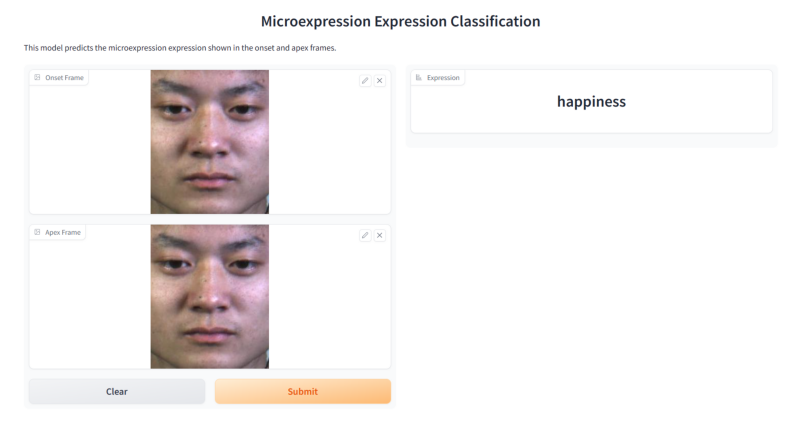

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image file
image_path = '/content/Screenshot (129).png'

# Load the image
img = mpimg.imread(image_path)

# Set the figure size and resolution
plt.figure(figsize=(10, 10), dpi=100)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis ticks and labels
plt.show()